# 05 Extract oil glands

Once all the exocarps have been isolated, we go a bit further and get oil gland tissue

- Just like the tissue extraction, this process in **not** fully automated
- The hyperparameters are set manually for each fruit
- Usually these hyperparameters are the same for all the fruits within the same raw scan

Once we have the oil gland tissue, we can also compute the center of mass of all the individual glands. Thus, for every fruit we have a point cloud determined by its oil glands.

- All the oil gland related information will be saved in a new `oil` directory following the same convention as for the rest of tissues:
```
oil/<root name>/<label name>/<root name>_<label name>_tissue.tif
```

<img src = "https://www.egr.msu.edu/~amezqui3/citrus/figs/SR01_L01_oil_glands.gif" alt = "barley" style="width:175px;"/>

In [1]:
import os
import sys
import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.ndimage as ndimage
import scipy.spatial as spatial
import numpy as np
import pandas as pd

import tifffile as tf
import citrus_utils as vitaminC

### Load the data

- Get the `init_src` path to where exocarp scans are stored
- Specify the citrus variety of interest.
    - Papedas fall within world relatives `WR`
- We'll select the fourth sample of Samuyao (`WR05_L03`)

In [2]:
init_src = '../data/tissue/'
ctrs_src = sorted(glob.glob(init_src + 'WR*/'))
ctrs_src

['../data/tissue/WR05_CRC3605_18B-19-5/',
 '../data/tissue/WR18_CRC2863_12A-39-9/']

In [3]:
src = ctrs_src[0]
L = 3
init_dst = '../data/oil/'

bname = src.split('/')[-2]
lname = 'L{:02d}'.format(L)

filename = src+ lname + '/'+ bname + '_' + lname + '_exocarp.tif'

dst = init_dst + bname + '/'
if not os.path.isdir(dst):
    os.makedirs(dst)
dst += lname + '/'
if not os.path.isdir(dst):
    os.makedirs(dst)
print(dst)

print(filename)
exo = tf.imread(filename).astype(np.uint8)
print(exo.shape)

../data/oil/WR05_CRC3605_18B-19-5/L03/
../data/tissue/WR05_CRC3605_18B-19-5/L03/WR05_CRC3605_18B-19-5_L03_exocarp.tif
(387, 392, 393)


### Observe the density distribution around the skin

- Oil glands are low density spots across the skin
- Threshold out by `thr` these low density spots
    - Ideally we would get a skin full of holes
- Fill in all those holes. This will be our main mask
- Get the tissue corresponding to the holes in the middle
    - Substract the thresholded skin image from the mask
    - We don't want low density spots on the surface (most likely air) or inside the flesh.

- Do an opening of the final result: this will remove 1-voxel-sized specks
- The end result can be quite sensitive to the initial `thr` value

[(inf, None, 145), (140, 96, 95), (14, 176, 177), (12, 191, 192), (12, 74, 73), (10, 178, 180), (10, 68, 67), (7, 194, 195), (7, 92, 91), (6, 182, 183), (5, 199, 200), (5, 186, 187), (5, 58, 57), (5, 52, 51), (4, 196, 197), (3, 214, 218), (3, 208, 213), (3, 55, 54), (2, 204, 206), (2, 174, 175), (1, 210, 209), (1, 201, 202), (1, 41, 40), (0, 221, 254), (0, 219, 220)]
134


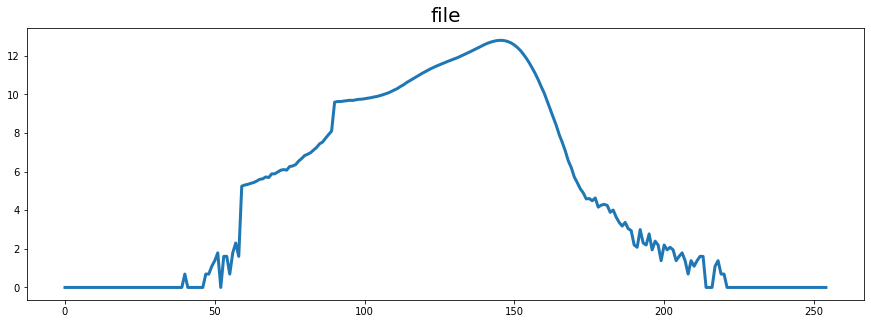

In [4]:
thr = vitaminC.get_individual_threshold(exo, True)
print(thr)

In [5]:
thr = 141

remove = 10
gtglands = exo.copy()
ltglands = exo.copy()
gtglands[gtglands < thr] = 0
ltglands[ltglands >= thr] = 0
ltglands[ltglands < remove] = 0
#gtglands[gtglands > 0] = 1
#gtglands = ndimage.binary_dilation(gtglands, iterations=2, structure=struc)

In [6]:
struc = ndimage.generate_binary_structure(exo.ndim, 1)
size = 9
cglands = gtglands.copy()
cglands = ndimage.grey_closing(cglands, size=(size,size,size), mode='constant')
#cglands = ndimage.grey_erosion(cglands, size=(3,3,3), mode='constant')
#cglands = ndimage.grey_opening(cglands, structure=struc, mode='constant')

In [7]:
mskglands = cglands.copy()
mskglands[mskglands > 0] = 1
lglands = ltglands*mskglands
print(np.sum(lglands > 0))

1495616


In [8]:
oiters = 1
ooilglands = lglands.copy()
ooilglands = ndimage.binary_opening(ooilglands, structure=struc, iterations=oiters)

oilglands = ooilglands*exo
print(np.sum(oilglands > 0))

841391


2 3


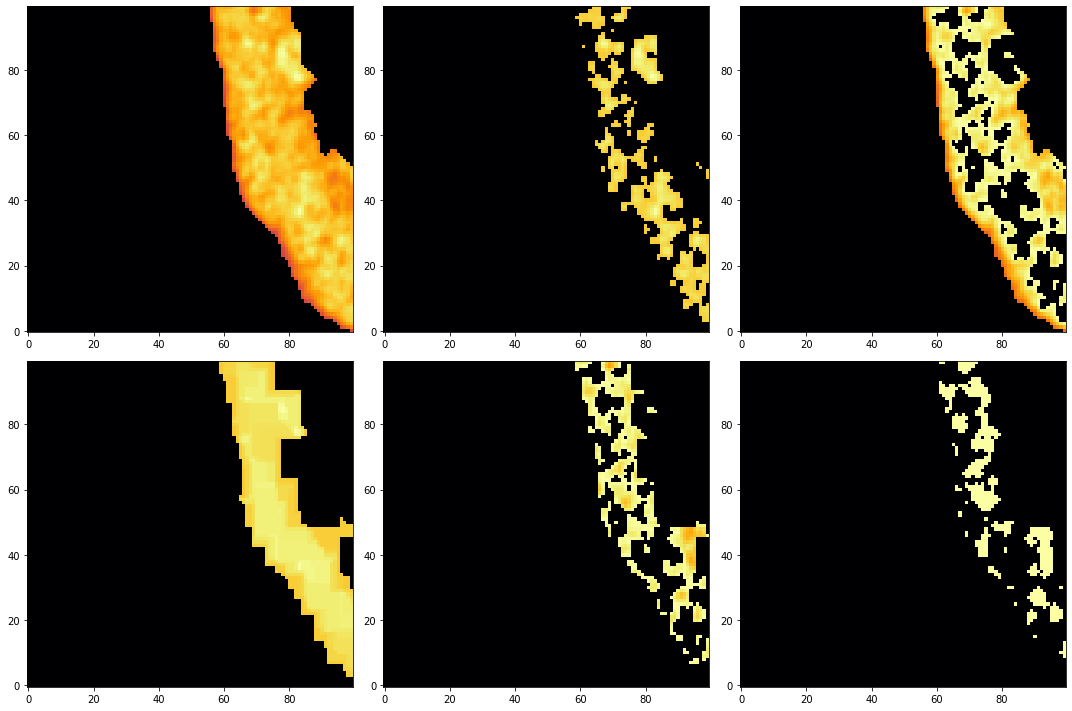

In [9]:
k = 350
ss = np.s_[100:200, k, 25:125]
#ss = np.s_[:,k,:]
vitaminC.plot4x4panel([exo, gtglands, ltglands, cglands, lglands, ooilglands], ss, bname=bname)

### Visual check

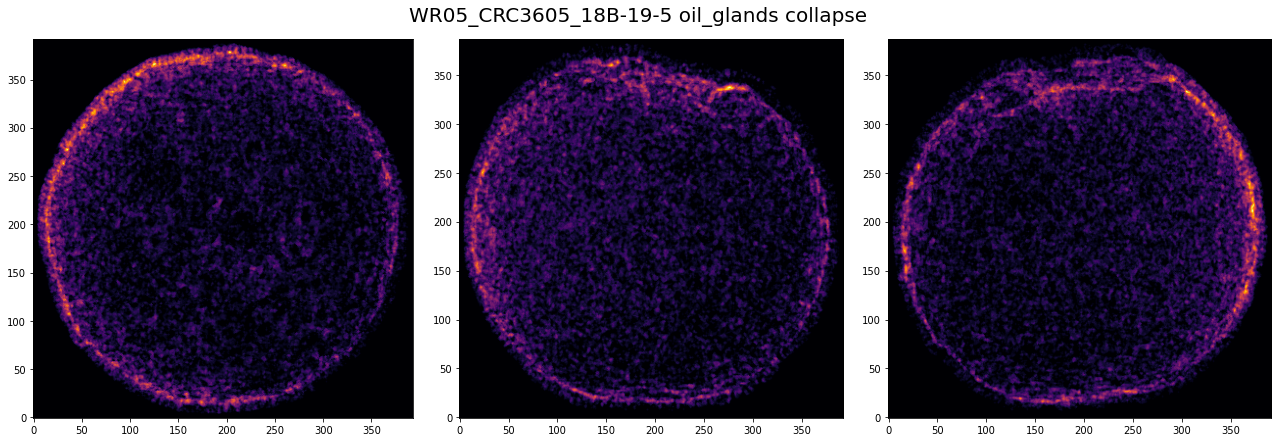

In [10]:
writefig = False
display  = True
diag_dst = init_dst + bname + '/'
snaps = vitaminC.collapse_dimensions(oilglands)
vitaminC.plot_collapse_dimensions(snaps, bname, 'oil_glands', display=display, writefig=writefig, dst=diag_dst)

## Clean up the oil gland clumps and get centers

We now need to get individual oil gland tissue components, corresponding to individual glands.

As a first step, we compute all the separate connected componets. There are a number of caveats, though:

- There are many 7-voxel-sized components that should be considered noise.
- Actually, discard all the components that are less than 21-voxels in size
- Compute the median size of the remaining connected components
- We expect all the actual oil glands to be at most `3*median` voxels in size

Any connected component larger than `3*median` will be considered a clump.

- Some of the glands might come in clumps
- We open the image to hopefully separate the majority of these clumps.
- Detect any new separate connected components of the right size.
- Open again the remaining clumps
- Keep opening and labeling separate connected components until all the clumps vanish.

In [11]:
labels,num = ndimage.label(oilglands, structure=struc)
print(num,'components')
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
argsort_hist = np.argsort(hist)[::-1]
print(hist[argsort_hist][:20])
print(np.median(hist))
print(np.mean(hist))
print(np.min(hist))
print(np.std(hist))

minsize = 3*np.min(hist)

new_hist = hist[hist > minsize]
maxsize = 3*np.median(new_hist)

print('maxsize',maxsize)

above_out = np.sum(hist > maxsize)
print('above_out',above_out)

below_out = np.sum(hist < minsize)
print('below_out', below_out)

print('Oil Glands = ', num - np.sum(hist<minsize))

7681 components
[135713  44006  32598  20520  17741  13186  12554   9422   8771   7154
   6725   6665   5419   3685   3516   3148   3098   2971   2933   2872]
22.0
109.54185652909777
7
1732.7540632673317
maxsize 162.0
above_out 552
below_out 3734
Oil Glands =  3947


In [12]:
npz = np.hstack(([0],1+np.argsort(argsort_hist)))

with np.nditer(labels, flags=['external_loop'], op_flags=['readwrite']) as it:
    for x in it:
        x[...] = npz[x]
        
binglands = oilglands.copy()
binglands[binglands > 0] = 1

normalsized = np.arange(above_out, num-below_out+1)
largesized = np.arange(1, above_out)
smallsized = np.arange(num - below_out+1, num+1)

In [13]:
center_mass_normal = np.array(ndimage.center_of_mass(binglands, labels=labels, index=normalsized))
binglands[labels >= above_out] = 0

I have noticed that `ndimage.center_of_mass` is expensive and doesn't need to applied until the very end.

- In the future I will make this loop way more efficient.

In [14]:
iters = oiters
largesized1 = largesized
above_out1 = 10
center_list = [center_mass_normal]
numgeq1 = True

obinglands = binglands.copy()
glands_tif = oilglands.copy()
glands_tif[glands_tif > 0] = 1
glands_tif[labels > num - below_out] = 0
glands_tif[labels < above_out] = 0

print('np.sum(binglands > 0)', np.sum(obinglands > 0))

while numgeq1 and above_out1 > 0 and (iters < 10):
    print('---\nIteration:',iters)
    iters += 1
    obinglands, labels1, normalsized1, largesized1, numgeq1 = vitaminC.refine_oil_gland(obinglands, maxsize, minsize, iters)
    if numgeq1 and len(normalsized1) > 0:
        center_mass_broken = np.array(ndimage.center_of_mass(obinglands, labels=labels1, index=normalsized1))
        center_list.append(center_mass_broken)
    
        above_out1 = len(largesized1)
        obinglands[labels1 >= above_out1] = 0
        print('np.sum(binglands > 0):', np.sum(obinglands > 0))



        glands_tif[labels1 > above_out1] = 1

np.sum(binglands > 0) 610698
---
Iteration: 1
1798 components
[2151 1906 1790 1424 1390 1244 1186 1173 1087 1051  967  959  952  929
  858  846  846  832  825  808]
above_out 304
below_out 0
1494 304
np.sum(binglands > 0): 107097
---
Iteration: 2
149 components
[413 401 380 373 358 329 313 281 262 257 248 233 220 217 211 202 188 188
 176 176]
above_out 23
below_out 0
126 23
np.sum(binglands > 0): 5772
---
Iteration: 3
3 components
[254 129 129]
above_out 1
below_out 0
2 1
np.sum(binglands > 0): 0
---
Iteration: 4
0 components


In [15]:
print(len(normalsized))
center_mass = np.vstack(center_list)
center_mass.shape

3396


(5018, 3)

In [16]:
center_mass = center_mass[~np.isnan(center_mass[:,0]),:]
center_mass.shape

(5018, 3)

Save the centers of mass of all the individual oil glands as `(x,y,z)` coordinates

In [17]:
filename = dst + bname + '_glandscenter.csv'
print(filename)
np.savetxt(filename, center_mass, fmt='%d', delimiter=',')

../data/oil/WR05_CRC3605_18B-19-5/L03/WR05_CRC3605_18B-19-5_glandscenter.csv


## Clean up the oil gland clumps and get a nice image

In [18]:
clean_glands = exo*glands_tif

In [19]:
filename = dst + bname + '_glands.tif'
print(filename)
tf.imwrite(filename, clean_glands, photometric='minisblack', compress=3)

../data/oil/WR05_CRC3605_18B-19-5/L03/WR05_CRC3605_18B-19-5_glands.tif


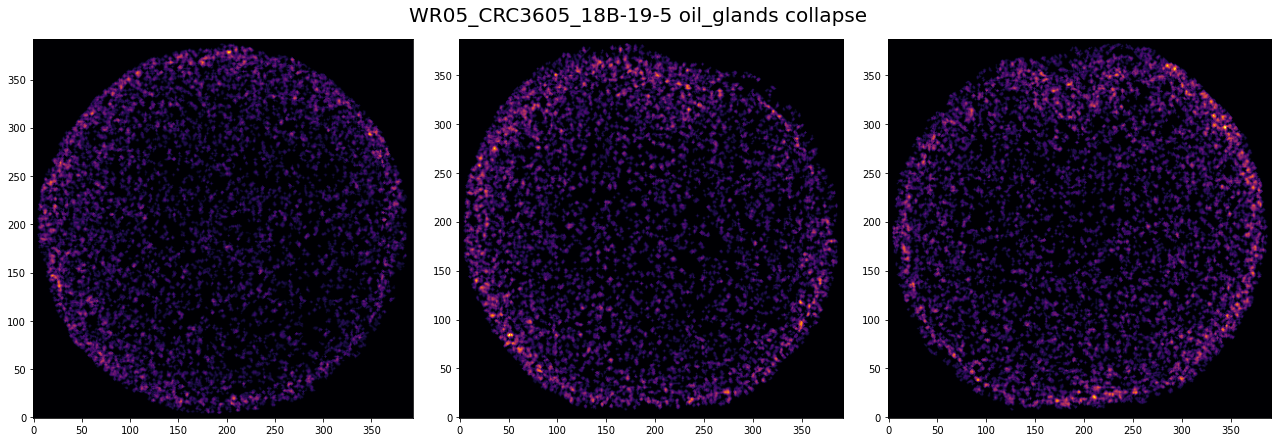

In [20]:
writefig = True
display  = True
diag_dst = init_dst + bname + '/L{:02d}_'.format(L)
snaps = vitaminC.collapse_dimensions(clean_glands)
vitaminC.plot_collapse_dimensions(snaps, bname, 'oil_glands', display=display, writefig=writefig, dst=diag_dst)